# Carregando as bibliotecas

* csv: Escreve os dados que vamos capiturar em formato `csv`
  * [Documentação oficial](https://docs.python.org/pt-br/3/library/csv.html)
  * [Reading and Writing CSV Files in Python](https://realpython.com/python-csv/) [en-us]
  * [CSV com Python](https://diegomariano.com/csv-com-python/) [pt-br]
  * [Como criar um arquivo CSV no Python](https://dicasdepython.com.br/como-criar-um-arquivo-csv-no-python/) [pt-br]
* json: Escreve os dados que vamos capiturar em formato `json`
  * [Documentação oficial](https://docs.python.org/3/library/json.html)
  * [Working With JSON Data in Python](https://realpython.com/python-json/) [en-us]
  * [Ler arquivos JSON em Python – Como usar load/loads e dump/dumps com arquivos JSON](https://www.freecodecamp.org/portuguese/news/ler-arquivos-json-em-python-como-usar-load-loads-e-dump-dumps-com-arquivos-json/) [pt-br]
* requests: Realiza requisições HTTP a páginas da internet
  * [Documentação oficial](https://docs.python-requests.org/en/latest/index.html)
  * [Python’s Requests Library (Guide)](https://realpython.com/python-requests/) [en-us]
  * [HTTP Request Methods](https://www.w3schools.com/tags/ref_httpmethods.asp) [en-us]
  * [Como começar a usar a biblioteca Requests em Python](https://www.digitalocean.com/community/tutorials/how-to-get-started-with-the-requests-library-in-python-pt) [pt-br]
  * [Métodos de requisição HTTP](https://developer.mozilla.org/pt-BR/docs/Web/HTTP/Methods) [pt-br]
  * [Uma visão geral do HTTP](https://developer.mozilla.org/pt-BR/docs/Web/HTTP/Overview) [pt-br]
* bs4/BeautifulSoup: Extrai informações de páginas HTML
  * [Documentação oficial](https://beautiful-soup-4.readthedocs.io/en/latest/)
  * [Beautiful Soup: Build a Web Scraper With Python](https://realpython.com/beautiful-soup-web-scraper-python/) [en-us]
  * [Como Fazer Scraping em Páginas Web com Beautiful Soup and Python 3](https://www.digitalocean.com/community/tutorials/como-fazer-scraping-em-paginas-web-com-beautiful-soup-and-python-3-pt) [pt-br]
  * [Beautiful Soup: parseamento de html](https://medium.com/pyladiesbh/beautiful-soup-parseamento-de-html-337197a7d4b9) [pt-br]
  

In [ ]:
import csv
import json
import requests
from bs4 import BeautifulSoup

# Criando o raspador (crawler)

## Acessando o LinkedIn

### Definindo URL

In [ ]:
linkedin_url = "https://www.linkedin.com/jobs/search"

Essa URL nós levará para essa página:

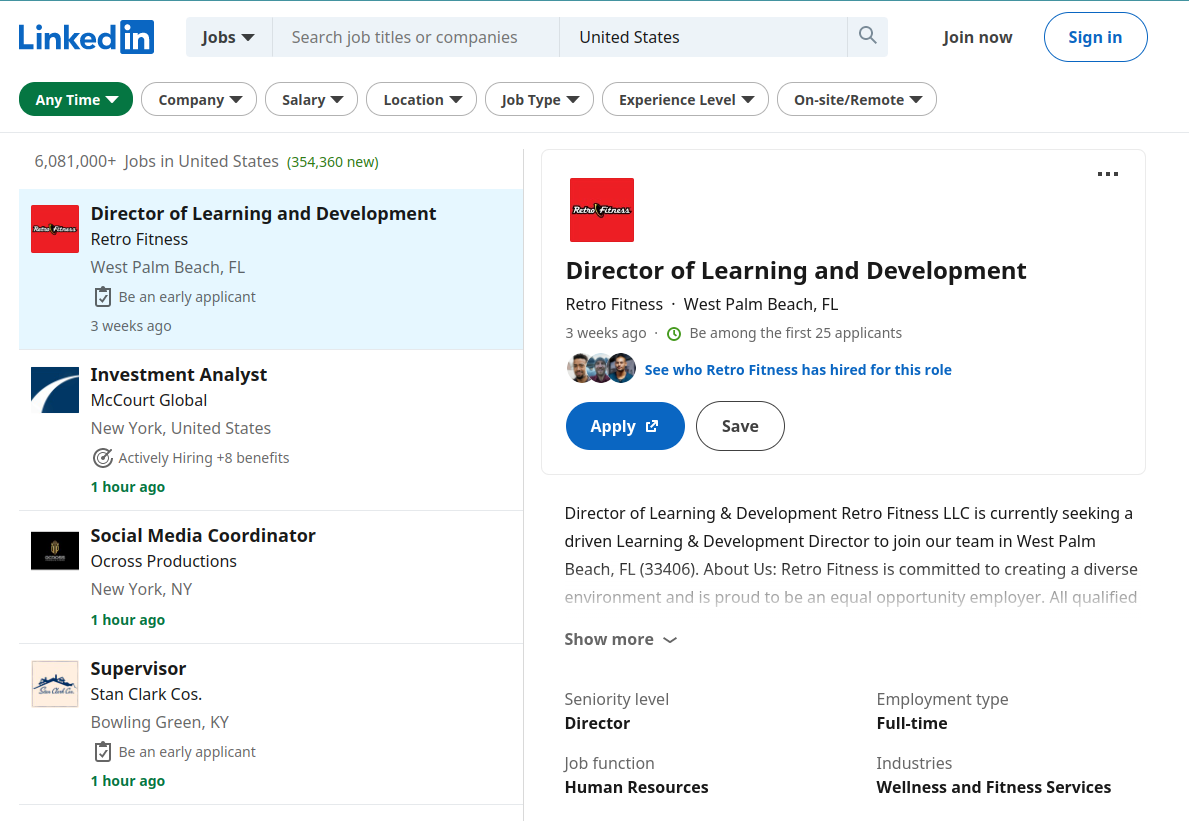

### Definindo filtro por localidade 

Se você notar na imagem anterior, apenas está sendo listado vagas nos **Estados Unidos**, porque no filtro superior direito está com o valor `United States`. Como queremos vagas no **Brasil**, vamos precisar filtrar por vagas no `Brazil`:

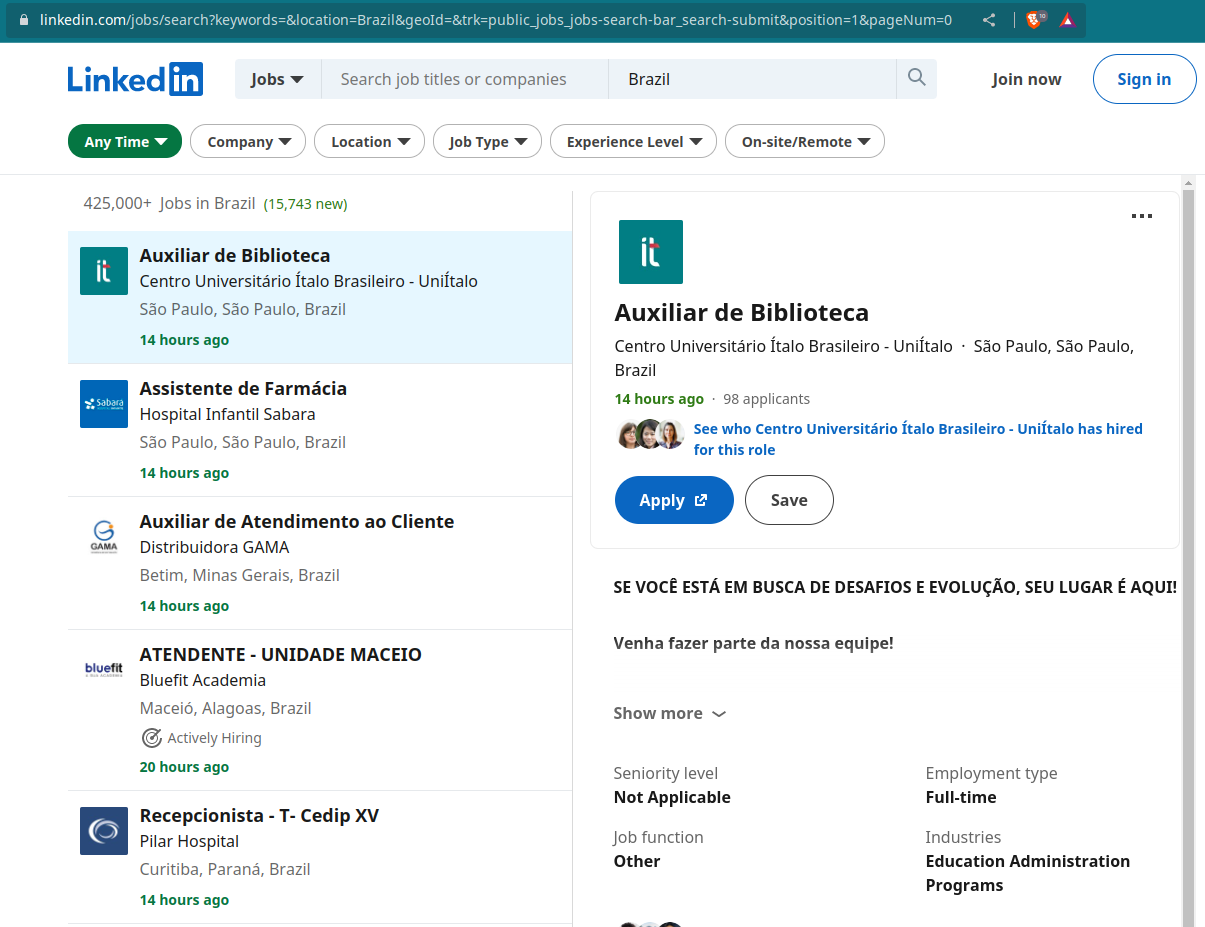

#### Como esse filtro realmente funciona?

Alterando os parâmetros na requisição (`GET`). Esses parâmetros são chamados de [`query string`](https://en.wikipedia.org/wiki/Query_string), eles são parte da URL e são importantes para passar informações (filtros) para os servidores da página que estamos tentando acessar. 

Nesse caso do LinkedIn, quando mudamos o filtro de localidade, a URL também muda:

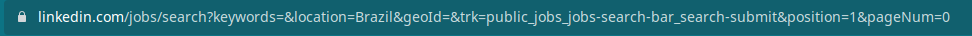

Nessa URL a `query string` é formada pelos seguintes parâmetros:
* keywords
* location
* geoId
* trk
* position
* pageNum

Cada conjunto de **parâmetro** e **valor** é dividido por um `&`, dessa forma, ficamos com a seguinte `query string`:

```
keywords=&location=Brazil&geoId=&trk=public_jobs_jobs-search-bar_search-submit&position=1&pageNum=0
```

#### Como definir esse mesmo filtro no python?

Criando um dicionário, onde as `chaves` serão os parâmetros da `query string`, e os `valores` do dicionário serão os conteúdo dos parâmetros:

In [ ]:
query_string = {
    "keywords": "Desenvolvedor Junior", # Titulo da vaga
    "location": "Brazil", # Localidade
    "trk": "guest_homepage-basic_guest_nav_menu_jobs" # Tracking do LinkedIn
}

## Acessando a página do LinkedIn

In [ ]:
response = requests.get(
    linkedin_url, 
    params=query_string
)

### Verificando se deu sucesso

O código do status da **resposta** (`response`) da requisição, é um bom indicativo se deu sucesso.

> Para saber mais quais os possíveis códigos, acesse [essa página](https://developer.mozilla.org/en-US/docs/Web/HTTP/Status).

In [ ]:
response.status_code

### Carregando a página HTML

Depois de ter verificado se a requisição que executamos foi com sucesso, vamos precisar pegar o conteúdo retornado (`response.content`) e converter para HTML, para que ai sim possamos extrair as informações que queremos.

#### Como é o conteúdo da resposta que recebemos?

*spoiler:* um HTML binário (tem um `b` na frente, isso significa que é binário)

In [ ]:
response.content

#### Convertendo para HTML

O `BeautifulSoup` é muito bom para isso, podemos fornecer o HTML binário e qual o formato que queremos, e ele gera um HTML legível.

In [ ]:
contexto = BeautifulSoup(response.content, 'html.parser')

contexto # HTML legível

## Trabalhando com HTML

> Nessa seção é interessante que você saiba sobre os [elementos do HTML](https://developer.mozilla.org/en-US/docs/Web/HTML/Element)

### Extraindo a lista de vagas

No HTML a lista de vagas está dentro de uma lista (`ul`). Essa lista para se diferenciar das outras possuí um atributo chamado `class`.

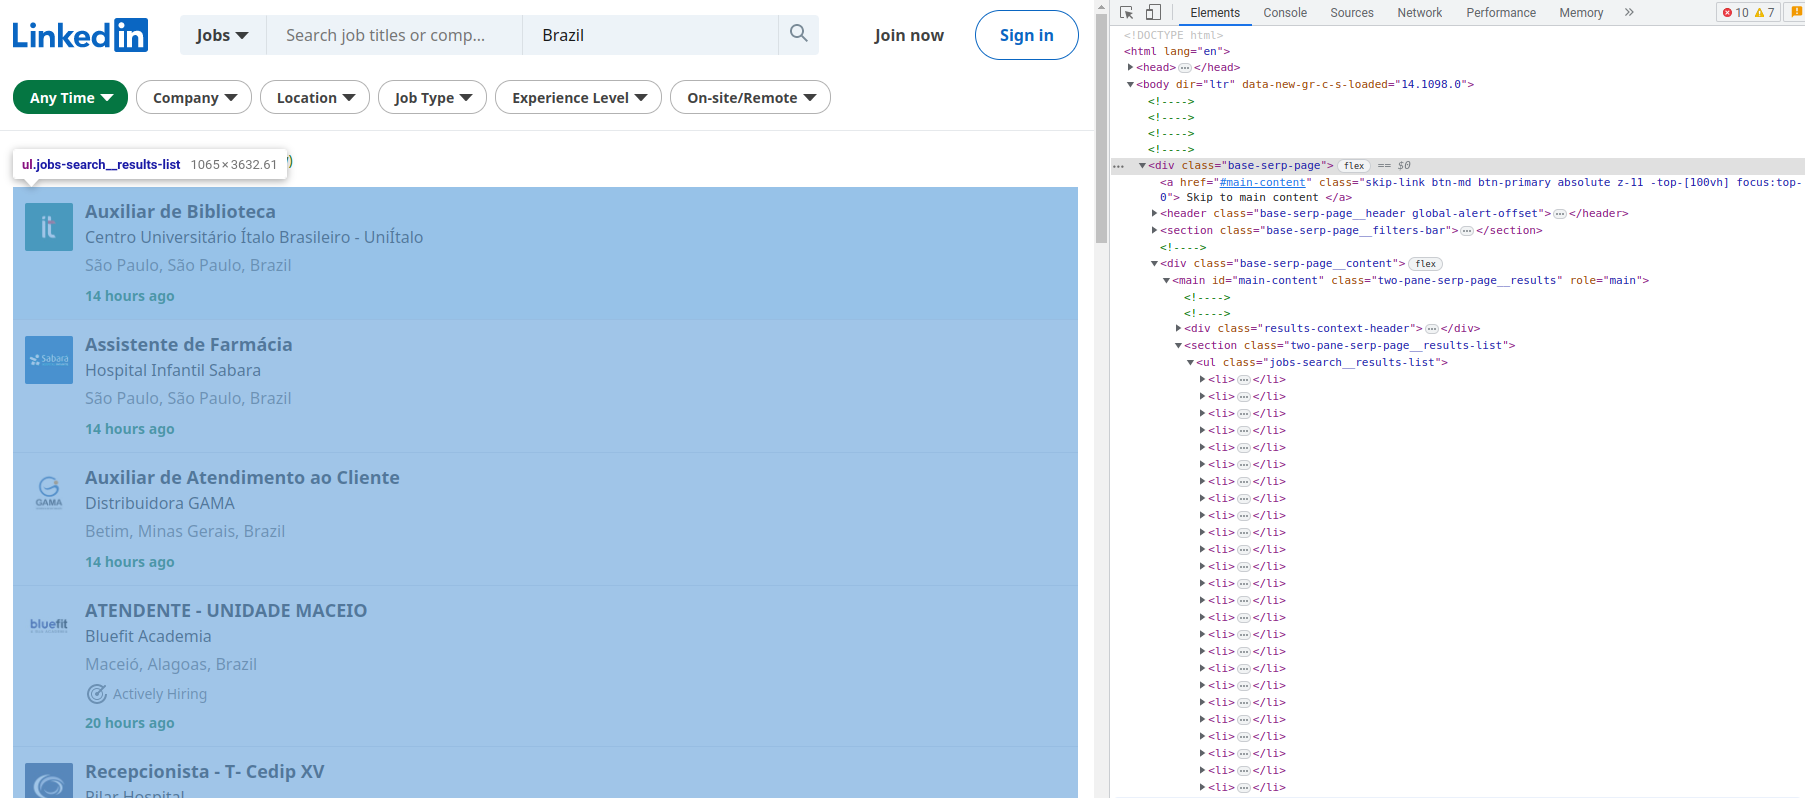

Dando um zoom nessa imagem, você pode ver que o conteúdo do `class` é `jobs-search__results-list`

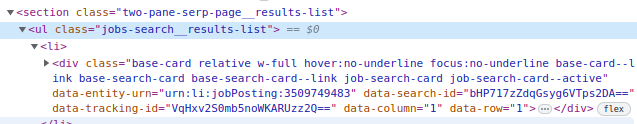

Sabendo dessas informações vamos selecionar todos os elementos dessa lista (`li`):

In [ ]:
lista_vagas = contexto.select(".jobs-search__results-list li")
lista_vagas

Você pode ver que foi retornado uma lista, com `25` elementos:

In [ ]:
len(lista_vagas)

### Percorrendo a lista de vagas e selecionando os atributos relevantes

Nesse exemplo, o que entendemos como atributos relevantes da vaga são:

* Titulo;
* Empresa;
* Localidade;
* Link com mais detalhes da vaga;
* Data de publicação da vaga.

Para fazer os testes a seguir, vamos trabalhar apenas com uma vaga:

In [ ]:
vaga = lista_vagas[0]
vaga

No momento em que eu estou escrevendo esse tutorial (03/03/2023 às 17h) a primeira vaga é a seguinte:

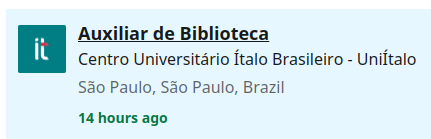 

Quando você estiver lendo esse tutorial, a lista de vagas estará bem diferente da minha. Por isso que nas imagens você vai ver uma coisa e quando você executar o código verá outra.

#### Onde está o título da vaga?

No elemento `h3` que tem o atributo `class` igual a `"base-search-card__title"`:
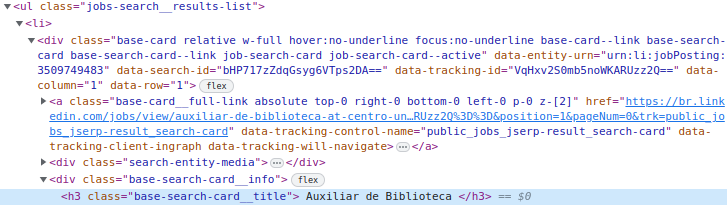

Vamos filtrar por todos os elementos que possuam `base-search-card__title`:

In [ ]:
vaga.select(".base-search-card__title")

Nesse exemplo só vamos ter um elemento, que coincidentemente é o elemento `h3` que falamos anteriormente. Sendo assim, vamos remover esse elemento dessa lista:

In [ ]:
vaga.select(".base-search-card__title")[0]

Agora queremos o texto que está dentro que está dentro desse elemento:

In [ ]:
vaga.select(".base-search-card__title")[0].text

VIIIXIII!! Não ficou muito legível! 

Um jeito de deixar esse texto mais legível é aplicar o [`strip`](https://www.w3schools.com/python/ref_string_strip.asp) :

In [ ]:
vaga.select(".base-search-card__title")[0].text.strip() 

Tarám!!! Agora sim temos o titulo da vaga de forma legível o/

#### Onde está o nome da empresa?

No elemento `h4` que tem o atributo `class` igual a `"base-search-card__subtitle"`:

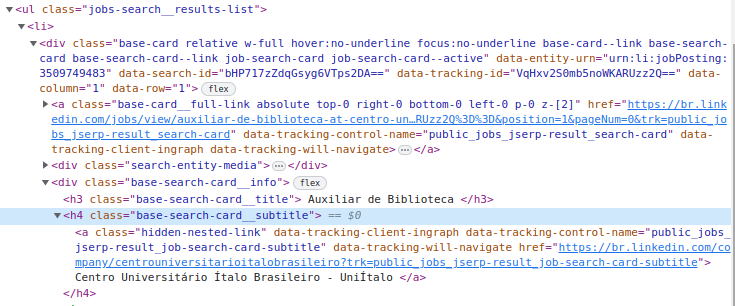

Com o nome da empresa vamos fazer exatamente a mesma coisa que fizemos anteriormente.

*Spoiler:*  Vamos fazer isso também nos outros casos :D A unica coisa que muda é em qual elemento está a informação que queremos.

In [ ]:
vaga.select(".base-search-card__subtitle")

In [ ]:
vaga.select(".base-search-card__subtitle")[0].text.strip()

#### Onde está a localidade da vaga?

No elemento `span` que tem o atributo `class` igual a `"job-search-card__location"`:

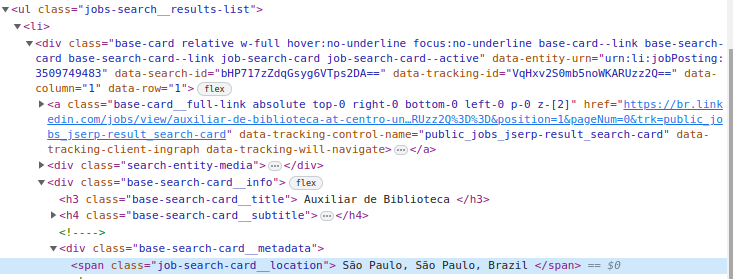

In [ ]:
vaga.select(".job-search-card__location")[0]

In [ ]:
vaga.select(".job-search-card__location")[0].text.strip()

#### Onde está o link com mais detalhes da vaga?

No elemento `a` que tem o atributo `class` igual a `"base-card__full-link"`:

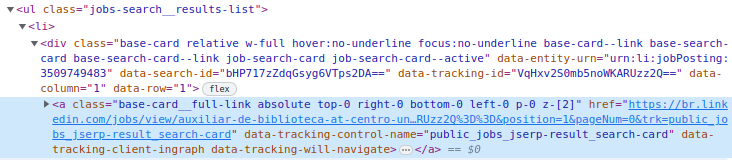

Nesse atributo para extrair ele vai ser um pouco diferente dos outros exemplos, porque nesse caso queremos o conteúdo do atributo `href` do elemento `a`.

Antes vamos filtrar por esse elemento:

In [ ]:
vaga.select(".base-card__full-link")

Como sempre só temos um resultado, por isso vamos extrair esse resultado da lista:

In [ ]:
vaga.select(".base-card__full-link")[0]

Agora vem o pulo do gato, para acessar um conteúdo de um atributo utilizamos o `.get("nome atributo")`:

In [ ]:
vaga.select(".base-card__full-link")[0].get("href")

#### Onde está a data de publicação da vaga?

No elemento `time`:

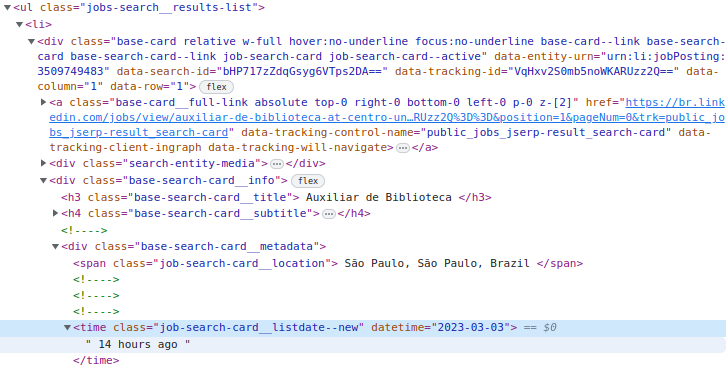

> Nesse caso como só temos um elemento `time` dentro de cada elemento da lista de vagas, não vamos precisar filtrar por nome da classe.

Assim como no exemplo anterior também queremos o conteúdo de um atributo dentro de um elemento, nesse caso o atributo `datetime`. 

In [ ]:
vaga.select("time")[0].get("datetime")

#### E se eu te falar que tem outro jeito de fazer isso que fizemos?

Não fica brava comigo :D 

No BeautifulSoup para extrair um elemento é possível utilizar `select()` ou `find()`. Nos exemplos que vimos anteriormente só utilizamos `select(css)`, onde `css` é a consulta em formato `css`.

Beleza... mas qual a diferença entre o `select()` e o `find()` ?

No primeiro conseguimos capturar **TODOS OS ELEMENTOS** que possuem as características que passamos na consulta. Enquanto que o segundo sempre retorna o **PRIMEIRO ELEMENTO** de um *determinado tipo* e *não podemos passar uma consulta `css`*. 

E ai, você acha que podemos substituir todos os `select()` que fizemos por `find()`?

Vamos tentar fazer isso com **titulo da vaga**:

In [ ]:
vaga.find(".base-search-card__title")

Não retornou nada... 

Lembra que não podemos filtrar por classes com o `find()`? :( 


E se eu filtrar por tipo de elemento?

In [ ]:
vaga.find("h3").text.strip()

Ok, no caso do **titulo da vaga funcionou**, vamos testar com os outros:

* Nome da empresa:

In [ ]:
vaga.find("h4").text.strip()

* Localidade da vaga:

In [ ]:
vaga.find("span").text.strip()

Esse não deu muito bom :(

* Link da vaga:

In [ ]:
vaga.find("a").get("href")

* Data de publicação:

In [ ]:
vaga.find("time").get("datetime")

#### Juntando tudo!

In [ ]:
titulo = vaga.find("h3").text.strip() 
empresa = vaga.find("h4").text.strip()
localidade = vaga.select(".job-search-card__location")[0].text.strip()

link = vaga.find("a").get("href")
data_publicacao = vaga.find("time").get("datetime")

print(f"Vaga: {titulo}")
print(f"Empresa: {empresa}")
print(f"Localidade: {localidade}")
print(f"Data de publicação: {data_publicacao}")
print(f"Link da vaga: {link}")

Que tal agora a gente fazer isso para todas as vagas da nossa lista?

In [ ]:
for vaga in lista_vagas:
    titulo = vaga.select(".base-search-card__title")[0].text.strip() 
    print(f"Vaga: {titulo}")

    empresa = vaga.select(".base-search-card__subtitle")[0].text.strip()
    print(f"Empresa: {empresa}")

    localidade = vaga.select(".job-search-card__location")[0].text.strip()
    print(f"Localidade: {localidade}")
    
    data_publicacao = vaga.find("time").get("datetime")
    print(f"Data de publicação: {data_publicacao}")
    
    if len(vaga.select(".hidden-nested-link")) == 0:
        link = vaga.select(".base-card")[0].get("href")
    else:
        link = vaga.select(".hidden-nested-link")[0].get("href")
    print(f"Link da vaga: {link}")

    print("########\n\n\n")

### Salvando os dados em um arquivo

Talvez no futuro você queira trabalhar analisando esses dados, ou você queira salvar eles de forma mais estruturada... O **Json** e o **CSV** são formatos muito utilizados para isso.

Antes vamos precisar criar um `dicionário`, onde as **chaves** serão os atributos da vaga e os **valores** serão os conteúdos dos atributos:

In [ ]:
info = {
    "vaga": titulo,
    "empresa": empresa,
    "localidade": localidade,
    "data_publicacao": data_publicacao,
    "link": link
}

info

Como não faz muito sentido fazer isso apenas para uma vaga, e sim para todas elas. Vamos armazenar cada um desses `dicionários` dentro de uma lista:

In [ ]:
lista_de_vagas = []

In [ ]:
for vaga in lista_vagas:
    titulo = vaga.select(".base-search-card__title")[0].text.strip() 
    empresa = vaga.select(".base-search-card__subtitle")[0].text.strip()
    localidade = vaga.select(".job-search-card__location")[0].text.strip()
    
    link = vaga.select(".base-card__full-link")[0].get("href")
    data_publicacao = vaga.find("time").get("datetime")
    
    info = {
        "vaga": titulo,
        "empresa": empresa,
        "localidade": localidade,
        "data_publicacao": data_publicacao,
        "link": link
    }
    
    lista_de_vagas.append(info)

In [ ]:
lista_de_vagas

Agora vem a melhor parte! Salvar todos os dicionários dentro de um arquivo de texto.

#### Json

Para escrever o conteúdo da lista `lista_de_vagas` em um arquivo `Json` vamos precisar passar a lista para formato de texto. Uma forma de fazer isso é com o `json.dumps()`:

In [ ]:
lista_de_vagas_json = json.dumps(lista_de_vagas)
lista_de_vagas_json

Agora sim! Vamos escrever esse texto gigante em um arquivo `json`:

In [ ]:
with open("vagas.json", "w") as arquivo_json:
    arquivo_json.write(lista_de_vagas_json)

> Acabou de ser criado dentro desse projeto um arquivo chamado `vagas.json`

#### CSV

O `CSV` diferente do `Json` precisa que seja fornecido qual vai ser o cabeçalho desse dado, para que depois seja escrito as linhas:

In [ ]:
with open('vagas.csv', mode='w') as arquivo_csv:
    cabecalho = ['vaga', 'empresa', 'localidade', "data_publicacao", "link"]
    gerador_csv = csv.DictWriter(arquivo_csv, fieldnames=cabecalho)
    gerador_csv.writeheader()
    gerador_csv.writerows(lista_de_vagas)

> Acabou de ser criado dentro desse projeto um arquivo chamado `vagas.csv`

# Parabéns! Você concluiu o treinamento!

Agora o céu é o limite! Segue algumas sugestões do que você pode tentar fazer daqui para frente:

1. Que tal raspar mais vagas além das 25 primeiras?
2. O que você acha de passar filtros um conjunto de filtros, de acordo com a ideia do usuário?
3. E análisar esses dados que você raspou da página?